In [3]:
# General syntax to import a library but no functions: 
#import (library) as (give the library a nickname/alias)
import pandas as pd
from pandas import DataFrame, read_csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.style.use('ggplot')

from scipy import stats

# Enable inline plotting
%matplotlib inline

"""
Create a function that calculates AIM from the output of the log file

This output is generated by Gromacs with AIM in the log file.

  N  CoulL   VdwL    Count   G  dG  dGCoulL  dGVdwL
  1  0.000  0.000    53354    0.00000   -0.10988  72.68642 -39.04117
  2  0.200  0.000    48592   -0.10988    0.03505  49.12180 -10.70077
  3  0.400  0.000    51103   -0.07483    0.02530  30.26744   4.34085
  4  0.600  0.000    53621   -0.04952    0.03545  16.23771  11.27888
  5  0.800  0.000    56754   -0.01408    0.01623   7.06221  13.62888
  6  1.000  0.000    58094    0.00215   -0.00223   0.22630  14.04047
  7  1.000  0.100    57396   -0.00007   -0.04135   0.21780  12.81567
  8  1.000  0.200    54913   -0.04142   -0.02937   0.15792  11.01799
  ...
  

For each log output I extract the output using bash cli:

for i in 1 2 3 4 5;
do;
$tail -135 out0$i.log | grep -A 24 "MC-lambda" | tr -d '<<' >> aimgpu0$i.out;
done

I then moved the files over to my laptop and made sure the format was correct.

"""
def quad_AIM(file_in, coulLambdas, vdwLambdas):
    # import the copied averages from the AIM simu
    location = file_in
    myDeltaG = pd.read_csv(
        location, 
        delim_whitespace=True)

    # only need the average values from the copied info
    dGdcoul = myDeltaG.dGCoulL
    dGdvdw = myDeltaG.dGVdwL

    # we only need the delta lambdas so we don't need a 2d array here
    dlamCoul = np.diff(coulLambdas, axis=0)
    dlamVdw = np.diff(vdwLambdas, axis=0)

    lv = []
    ave_dhdl = []
    for i in range(len(coulLambdas)):
        lv.append([coulLambdas[i], vdwLambdas[i]])
        ave_dhdl.append([dGdcoul[i], dGdvdw[i]])

    lv = np.array(lv)
    ave_dhdl = np.array(ave_dhdl)
    K, n_components = lv.shape
    lchange = get_lchange(lv, K, n_components)
    cubspl, mapl = getSplines(lchange, K, n_components, lv)

    dlam = []
    for i in range(len(dlamCoul)):
        dlam.append([dlamCoul[i], dlamVdw[i]])
    dlam = np.array(dlam)

    aim = 0
    aimcubic = 0.0
    for k in range(K-1):
        aim += 0.5*np.dot(dlam[k],(ave_dhdl[k]+ave_dhdl[k+1]))
        for j in range(n_components):
            if dlam[k,j] > 0:
                lj = lchange[:,j]
                aimcubic += np.dot(cubspl[j].wk[mapl[k,j]],ave_dhdl[lj,j])
 
    return(aim, aimcubic)

def hist_flatness(file_in, label):
    ###############################################################################
    # Is it flat enough?  Is the minimum entry less than 80% of its average value?
    # It is common practice to considr a histogram "sufficiently flat" when its
    # minimum entry is no less than 80% of its average value.
    ###############################################################################
    location = file_in
    myDeltaG = pd.read_csv(
        location, 
        delim_whitespace=True)
    
    dfnum = np.array(myDeltaG.Count)
    flatness = 100*(min(dfnum)/np.average(dfnum))
    if flatness > 80:
        flat = "It's flat"
    else:
        flat = "Not flat"

    plt.figure
    plt.title("Lambda Histogram", fontsize=22)
    plt.grid(True)
    plt.xlabel("Lambda Values", fontsize=22)
    plt.ylabel("Count at Lambda", fontsize=22)
    plt.xlim(-0.01,1.02)
    plt.ylim(0.5*min(dfnum),2*max(dfnum))
    x = np.linspace(0,1,len(dfnum))
    y = dfnum
    plt.plot(x, y,label="sim "+label+" "+flat)
    legend = plt.legend(loc='upper center')

class naturalcubicspline:

    def __init__(self, x):

        # define some space
        L = len(x)
        H = np.zeros([L,L],float)
        M = np.zeros([L,L],float)
        BW = np.zeros([L,L],float)
        AW = np.zeros([L,L],float)
        DW = np.zeros([L,L],float)

        h = x[1:L]-x[0:L-1]
        ih = 1.0/h

        # define the H and M matrix, from p. 371 "applied numerical methods with matlab, Chapra"
        H[0,0] = 1
        H[L-1,L-1] = 1
        for i in range(1,L-1):
            H[i,i] = 2*(h[i-1]+h[i])
            H[i,i-1] = h[i-1]
            H[i,i+1] = h[i]

            M[i,i] = -3*(ih[i-1]+ih[i])
            M[i,i-1] = 3*(ih[i-1])
            M[i,i+1] = 3*(ih[i])

        CW = np.dot(np.linalg.inv(H),M)  # this is the matrix translating c to weights in f.
                                                       # each row corresponds to the weights for each c.

        # from CW, define the other coefficient matrices
        for i in range(0,L-1):
            BW[i,:]    = -(h[i]/3)*(2*CW[i,:]+CW[i+1,:])
            BW[i,i]   += -ih[i]
            BW[i,i+1] += ih[i]
            DW[i,:]    = (ih[i]/3)*(CW[i+1,:]-CW[i,:])
            AW[i,i]    = 1

        # Make copies of the arrays we'll be using in the future.
        self.x  = x.copy()
        self.AW = AW.copy()
        self.BW = BW.copy()
        self.CW = CW.copy()
        self.DW = DW.copy()

        # find the integrating weights
        self.wsum = np.zeros([L],float)
        self.wk = np.zeros([L-1,L],float)
        for k in range(0,L-1):
            w = DW[k,:]*(h[k]**4)/4.0 + CW[k,:]*(h[k]**3)/3.0 + BW[k,:]*(h[k]**2)/2.0 + AW[k,:]*(h[k])
            self.wk[k,:] = w
            self.wsum += w

    def interpolate(self,y,xnew):
        if len(self.x) != len(y):
            parser.error("\nThe length of 'y' should be consistent with that of 'self.x'. I cannot perform linear algebra operations.")
        # get the array of actual coefficients by multiplying the coefficient matrix by the values
        a = np.dot(self.AW,y)
        b = np.dot(self.BW,y)
        c = np.dot(self.CW,y)
        d = np.dot(self.DW,y)

        N = len(xnew)
        ynew = np.zeros([N],float)
        for i in range(N):
            # Find the index of 'xnew[i]' it would have in 'self.x'.
            j = np.searchsorted(self.x, xnew[i]) - 1
            lamw = xnew[i] - self.x[j]
            ynew[i] = d[j]*lamw**3 + c[j]*lamw**2 + b[j]*lamw + a[j]
        # Preserve the terminal points.
        ynew[0] = y[0]
        ynew[-1] = y[-1]
        return ynew

def get_lchange(lv, K, n_components):
    lchange = np.zeros([K,n_components],bool)   # booleans for which lambdas are changing
    for j in range(n_components):
        # need to identify range over which lambda doesn't change, and not interpolate over that range.
        for k in range(K-1):
            if (lv[k+1,j]-lv[k,j] > 0):
                lchange[k,j] = True
                lchange[k+1,j] = True
    return lchange

def getSplines(lchange, K, n_components, lv):
    # construct a map back to the original components
    mapl = np.zeros([K,n_components],int)   # map back to the original k from the components
    for j in range(n_components):
        incr = 0
        for k in range(K):
            if (lchange[k,j]):
                mapl[k,j] += incr
                incr +=1

    # put together the spline weights for the different components
    cubspl = list()
    for j in range(n_components):
        lv_lchange = lv[lchange[:,j],j]
        if len(lv_lchange) == 0: # handle the all-zero lv column
            cubspl.append(0)
        else:
            spl = naturalcubicspline(lv_lchange)
            cubspl.append(spl)
    return cubspl, mapl

AIM sim 1 = 21.72948675
AIM_cubic sim 1 = 21.4305180043
AIM sim 2 = 21.71768375
AIM_cubic sim 2 = 21.4130606393
AIM sim 3 = 21.759188
AIM_cubic sim 3 = 21.4562814194
AIM sim 4 = 21.729912
AIM_cubic sim 4 = 21.4335522179
AIM sim 5 = 21.66862425
AIM_cubic sim 5 = 21.3701979077
The average is  21.72097895
The cubic average is  21.4207220377


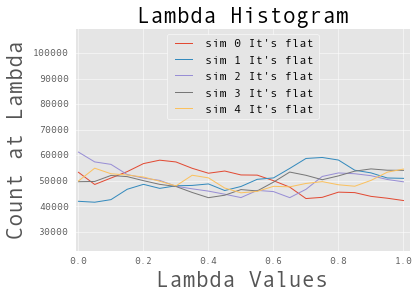

In [4]:
# need the lambda arrays
coulLambdas = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
vdwLambdas = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])

totals = []
cubics = []
for i in range(5):
    file_in = "aimgpu0"+str(i+1)+".out"
    aim, aim_cubic = quad_AIM(file_in, coulLambdas,vdwLambdas)
    hist_flatness(file_in, str(i))
    print "AIM sim "+str(i+1)+" = "+str(aim)
    print "AIM_cubic sim "+str(i+1)+" = "+str(aim_cubic)
    totals.append(aim)
    cubics.append(aim_cubic)
    
print "The average is ",np.array(totals).mean()
print "The cubic average is ",np.array(cubics).mean()

/Users/ChrisM/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:2748: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/Users/ChrisM/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


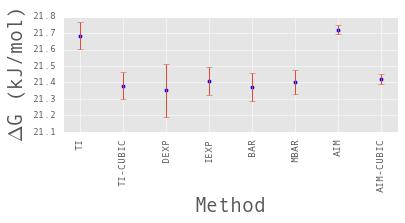

In [5]:
# Use Pymbar to get the results
# make sure to skip half of the xvg file
# Command line was: /Users/ChrisM/anaconda/bin/alchemical_analysis -t 300 -x -v -p prod -s 500 -i 0

# Get the result from each run to look like this
# 5 ns
#         TI  TI-CUBIC DEXP    IEXP    BAR  MBAR    AIM
# run01 18.782 18.524 18.349 18.633 18.522 18.510 15.22232
# run02 18.776 18.496 18.398 18.538 18.535 18.561 15.34766
# run03 18.665 18.404 18.218 18.541 18.402 18.438 15.39739
# run04 18.679 18.410 18.382 18.594 18.417 18.471 15.20885
# run05 18.679 18.400 18.316 18.543 18.408 18.441 15.09506

# Plot the results using error bars for each lambda window 1ns, 5ns, 10ns
location = "compare_five_ns.log"
myResults = pd.read_csv(
    location, 
    delim_whitespace=True,
    header = None)
myResults.drop([1,2,4,5,7,8,10,11,13,14,16,17], axis=1, inplace=True)
myResults = myResults.rename(index=str, columns={0:"TI",3:"TI-CUBIC",6:"DEXP",9:"IEXP",12:"BAR",15:"MBAR"})
myResults['AIM'] = np.array(totals)
myResults['AIM-CUBIC'] = np.array(cubics)

plt.close()
labels = list(myResults.columns.values)
y = np.array(myResults.mean().values)
x = range(len(y))
plt.close()
plt.xticks(x, labels, rotation='vertical')
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.5)
plt.ylabel("$\Delta$G (kJ/mol)", fontsize = 20)
plt.xlabel('Method', fontsize = 20)
plt.errorbar(x, y, yerr=np.std(myResults), fmt=None)
plt.scatter(x, y)

# Create a simple legend
plt.legend(loc=0, borderaxespad=0., fontsize=14, ncol=1)
plt.style.use('ggplot')

# Finally, save the figure as a png.  
# You can also save it as a PDF, JPEG, etc.  
# Just change the file extension in this call.  
# bbox_inches="tight" removes all the extra whitespace on the edges of your plot.  
plt.savefig("fivens_compared.png", bbox_inches="tight", dpi=300);